# Panda Example

In [1]:
import sys
sys.path.append('lib')

import scipy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time, os
from IPython.display import clear_output
from IPython.core import display

import pybullet as p
import pybullet_data
import networkx as nx

import pinocchio as pin
from utils import *
from costs import *
from robot import *
from functools import partial

import tensorflow as tf
import tensorflow.compat.v1 as tf1
from collections import OrderedDict
import tf_robot_learning as rl
import tf_robot_learning.distributions as ds
from tf_robot_learning import kinematic as tk

DATA_PATH = '/home/teguh/git/publications/learning_distribution_gan/tf_robot_learning/data'

%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=True)

## Part 1: Define and Train GAN

In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

### Define the robot

In [3]:
#define the robot as a kinematic chain, loaded from urdf
urdf = tk.urdf_from_file(DATA_PATH + '/urdf/panda_arm.urdf');
chain = tk.kdl_chain_from_urdf_model(
    urdf, tip='panda_hand'
)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Material has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: materialMaterial has neither a color nor textureUnknown tag: material

### Load data

In [4]:
data = np.load('data/panda_constrained_orientation.npy')

In [5]:
data = data[:25000]

In [6]:
def q_augmented(q):
#     return q
    return tf.concat([q, fs[0](q)], axis=1)

In [7]:
# get mini batch
def get_batch(_batch_size=30, cut=None, augmented=True):
    if cut is not None: idx = np.random.randint(0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    if augmented: return data_augmented[idx]
    else: return data[idx]
    
def get_target_batch(_batch_size=30, cut=None):
    if cut is not None: idx = np.random.randint( 0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    return data_target[idx]

In [8]:
# define transformations of interest (task-spaces)
fs = [
    lambda q : chain.xs(q)[:, -1], # get position and orientation of end-effector
    lambda q : chain.xs(q)[:, -1, :3], # get position end-effector
]

In [9]:
# some utilities to evaluate these functions in tensorflow
q_eval = tf1.placeholder(tf.float32, (None,7))
x_eval = chain.xs(q_eval)
           
q_augmented_eval = q_augmented(q_eval)
q_target_eval = fs[1](q_eval)

In [10]:
# compute data through these transformations
data_augmented = q_augmented_eval.eval({q_eval: data})
data_target = q_target_eval.eval({q_eval: data})

### Model parameters 

In [11]:
# Network Parameters
joint_dim = 7 # panda joint angles
latent_dim = 10 # dimension of noise

target_dim = 3  # size of the target

augmented_dim = data_augmented.shape[-1]  # size of augmented data

batch_size = tf1.placeholder(tf.int32, ())

N_net = 10 # number of NNs

## Generator  

In [12]:
gen_nn = rl.nn.MLP(
    n_input=latent_dim + target_dim, n_output=joint_dim, n_hidden=[200, 200],
    act_fct=tf.nn.relu, batch_size_svi=N_net
)

#### Define the input to generator

In [13]:
# noise to feed generator
eps = tf.random.normal([tf.cast(batch_size/N_net, tf.int32), latent_dim], 
    dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')

# target parameters to feed generator
batch_target = tf1.placeholder(tf.float32, (None, target_dim))

# to feed main generator noise + parameters samples
eps_conc = tf.concat([eps, batch_target], axis=-1)

#### Generator output

In [14]:
# main generator
samples_q = tf.reshape(gen_nn.pred(eps_conc) + tf.constant(chain.mean_pose)[None], (-1,joint_dim))
# compute links of main generator
samples_x = chain.xs(samples_q)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Input with varying noise

In [15]:
# second generator for using the model later with given targets and changing noise
std_guided = tf1.placeholder(tf.float32, ())
eps_guided = tf.random.normal([batch_size, latent_dim], 
    dtype=tf.float32, mean=0., stddev=std_guided, name='epsilon')

guided_samples_q = tf.reshape(gen_nn.pred(
    tf.concat([eps_guided, batch_target], axis=-1)) + tf.constant(chain.mean_pose)[None], (-1,joint_dim))
guided_samples_x = chain.xs(guided_samples_q)

## Discriminator

In [16]:
discr_nn = rl.nn.MLP(
    n_input=augmented_dim, n_output=1, n_hidden=[20, 20],
    act_fct=tf.nn.relu
)

## Define the loss functions

In [17]:
# data in
batch_x = tf1.placeholder(tf.float32, (None, augmented_dim))

In [18]:
# probability to belong to data for data and samples
d_fake = discr_nn.pred(q_augmented(samples_q))[:, 0]
d_true = discr_nn.pred(batch_x)[:, 0]

#### Main loss function (discriminator + generator)

In [19]:
loss_d = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_true), logits=d_true) + \
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake), logits=d_fake)
loss_d = tf.reduce_sum(loss_d)

#### Generative loss

In [20]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(d_fake), logits=d_fake)
loss = tf.reduce_sum(loss)

#### Target loss 

In [21]:
p_target_std = tf1.placeholder(tf.float32, ()) 

p_target = ds.MultivariateNormalFullCovariance(
    tf.reshape(tf.ones((N_net, 1,1))*batch_target[None],(-1, target_dim)), p_target_std**2 * tf.eye(3))
    
samples_target_proj = fs[1](samples_q)

loss_target = tf.reduce_sum(-p_target.log_prob(samples_target_proj))
lmbda_target = tf1.placeholder(tf.float32, ())

Instructions for updating:
Do not call `graph_parents`.


#### Constraints Costs

In [22]:
lmbda_constraints = tf1.placeholder(tf.float32, ())
joint_limits = tf.constant(chain.joint_limits, dtype=tf.float32)
joint_limits_std = 0.05
joint_limits_temp = 1.

joint_limits_exp = ds.SoftUniformNormalCdf(
    low=joint_limits[:, 0],
    high=joint_limits[:, 1],
    std=joint_limits_std,
    temp=joint_limits_temp,
    reduce_axis=-1
)
joint_limit_constraints = tf.reduce_mean(-joint_limits_exp.log_prob(samples_q))

#### Overall loss 

In [23]:
loss_gen =  lmbda_target * loss_target + lmbda_constraints*joint_limit_constraints + loss

#### Optimizers 

In [24]:
rate = tf1.placeholder(tf.float32, ())
opt = tf1.train.AdamOptimizer

optimizer = opt(learning_rate=rate)
optimizer_d = opt(learning_rate=rate)

gen_var = gen_nn.vec_weights
train = optimizer.minimize(loss_gen, var_list=gen_var)
train_d = optimizer_d.minimize(loss_d, var_list=discr_nn.vec_weights)

# Initialize the variables (i.e. assign their default value)
init = tf1.global_variables_initializer()

#### Train GAN

In [25]:
sess.run(init)

In [26]:
_batch_size = 100
alpha = 0.5

tic = time.time()
for i in range(10000):
    try:
        for j in range(5):
            # train discriminative_network
            _x = get_batch(_batch_size=_batch_size)
#             _x =np.copy(_x) + np.random.normal(0., 0.05, (_batch_size, augmented_dim))
            feed_dict = {
                lmbda_target: .1,
                lmbda_constraints: 1.,
                p_target_std: 0.05,
                batch_x: _x,
                batch_size: _batch_size,
                rate : 0.002 * alpha
            }
            feed_dict[batch_target] = get_target_batch(_batch_size=int(_batch_size/N_net))

            _ = sess.run([train_d], feed_dict=feed_dict)
        
        feed_dict[rate] = 0.001 * alpha
        # train generative_network
        _, _loss, _loss_target, _loss_d = sess.run(
            [train, loss, loss_target, loss_d], feed_dict=feed_dict)
        
        if not i % 10:
            display.clear_output(wait=True)
            print('Step %i\t, Loss gen: %f\t, loss discr %f, loss target %f' % (i, _loss, _loss_d, _loss_target))
    except KeyboardInterrupt:
        toc = time.time()
        print(toc-tic)
        break
        
toc = time.time()
print(toc-tic)


Step 9990	, Loss gen: 122.411461	, loss discr 93.164299, loss target 92.852104
321.1899609565735


#### To save model


#### To load model

#### Plot distribution

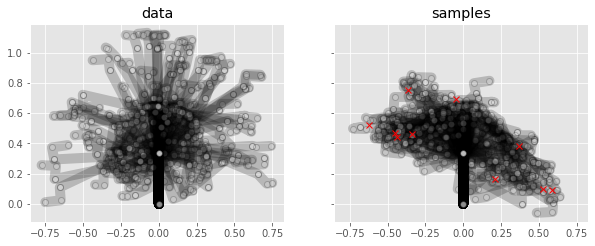

In [27]:
n = 100
# _targets = np.random.multivariate_normal(
                        # [0.4, 0., 0.2], 0.3 ** 2 * np.eye(3), (n,))
_targets = get_target_batch(_batch_size=int(n/N_net))

_samples_q,_samples_xs = sess.run([
        samples_q, samples_x], {batch_size: n, batch_target: _targets})
    
_data_q = get_batch(n, augmented=False) 
_data_q += np.random.normal(0., 0.05, (n, 7))
_data_xs =  sess.run(x_eval, feed_dict={q_eval: _data_q})


fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))

dims = [0, 2]
ax[0].set_title('data')
chain.plot(_data_xs, dim=dims, alpha=0.2, color='k', ax=ax[0])
ax[1].set_title('samples')
chain.plot(_samples_xs, dim=dims, alpha=0.2, color='k', ax=ax[1])

ax[1].plot(_targets[:, dims[0]], _targets[:, dims[1]], 'rx')


#### Plot target distribution 

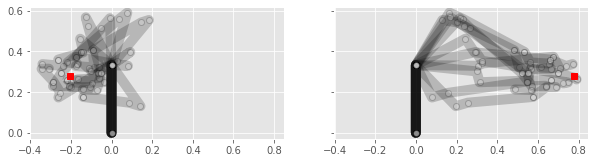

In [28]:
n = 1

_target = get_target_batch(cut=5000, _batch_size=1)[0]
# _target = np.random.multivariate_normal([0.4, 0., 0.2], 0.2 ** 2 * np.eye(3))
_targets = _target[None] * np.ones((n, 1)) 

_samples_x = guided_samples_x.eval({batch_size: n, std_guided: .1, batch_target: _targets})

_data_q = get_batch(n, augmented=False)
_data_xs =  sess.run(x_eval, feed_dict={q_eval: _data_q})


fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 3))

for i in range(2):
    dims = [i, 2]
    chain.plot(_samples_x, dim=dims, alpha=0.2, color='k', ax=ax[i])
    ax[i].plot(_targets[0][dims[0]], _targets[0][dims[1]], 'rs')

## Part 2: Use it for Projection, IK and Inverse Kinematics

### Setup Pybullet

In [29]:
physics_client_id = p.connect(p.DIRECT)
p.setPhysicsEngineParameter(enableFileCaching=0)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

In [30]:
p.resetSimulation()

### Setup Robot & environment

In [32]:
robot_urdf = DATA_PATH + '/urdf/panda_arm.urdf'
robot_id = p.loadURDF(fileName=robot_urdf)
dof = p.getNumJoints(robot_id)
pb_joint_indices = np.arange(7)
joint_limits = get_joint_limits(robot_id,pb_joint_indices)
mean_pose = 0.5*(joint_limits[0]+joint_limits[1])

plane_id = p.loadURDF('plane.urdf')
p.resetBasePositionAndOrientation(plane_id, (0,0,-.5), (0,0,0,1))

table_square_id = p.loadURDF('table_square/table_square.urdf')
p.resetBasePositionAndOrientation(table_square_id, (0.,0,-0.64), (0, 0, 0.7071068, 0.7071068))

table_id = p.loadURDF('table/table.urdf')
p.resetBasePositionAndOrientation(table_id, (.7,0,-0.5), (0, 0, 0.7071068, 0.7071068))

shelf_urdf = DATA_PATH + '/urdf/bookshelf_simple_collision.urdf'
shelf_id = p.loadURDF(fileName=shelf_urdf)
p.resetBasePositionAndOrientation(shelf_id, (-0.6,0.6,-0.5), (0, 0, 0, 1.))

#for visualizing the desired target
_,_,ball_id = create_primitives(radius=0.05)

### Load model in pinocchio

In [33]:
robot_urdf = DATA_PATH + '/urdf/panda_arm.urdf';
rmodel = pin.buildModelFromUrdf(robot_urdf)
rdata = rmodel.createData()

pin_frame_names = [f.name for f in rmodel.frames]
ee_frame_id = rmodel.getFrameId('panda_hand2')
ee_frame_id2 = rmodel.getFrameId('panda_hand2')


#### Define standard functions

In [34]:
computeJacobian_std = partial(computeJacobian, rmodel, rdata, ee_frame_id)
computePose_std = partial(computePose, rmodel, rdata, ee_frame_id)
set_q_std = partial(set_q,robot_id, pb_joint_indices)

***

## Using Cost Model for projection

In [35]:
class CostProjector():
    def __init__(self, cost):
        self.cost = cost
    
    def __call__(self, xk):
        if False not in self.cost.feasibles:    
            #print('Stop at iteration!' + str(self.cost.nfev))
            raise Exception
        
    def project(self, q, ftol = 1e-12, gtol = 1e-12, disp = 0, maxiter = 1000 ):
        #update the variables
        self.cost.reset_iter()
        
        if 'posture' in self.cost.costnames:
            #regularizing around the initial q
            self.cost.costs['posture'].cost.desired_posture = q.copy()
        
        if 'ori_cost' in self.cost.costnames:
            #maintain the current EE pose while correcting its orientation
            pos, ori = computePose_std(q)
            self.cost.costs['ori_cost'].cost.desired_pose[:3] = pos

        status = False
        try:
            res = minimize(self.cost.calc,q,method='l-bfgs-b', jac=self.cost.calcDiff, callback=self.__call__, options={'ftol':ftol, 'gtol':gtol, 'disp':disp, 'maxiter':maxiter})      
        except:
            #Optimization manage to get solution
            status = True
        res = {'stat':status, 'q':  self.cost.qs[-1], 'qs': self.cost.qs, 'nfev': self.cost.nfev, 'feval': self.cost.feval}
        return res

In [36]:
data_target = []
for i in range(data.shape[0]):
    pos, ori = computePose_std(data[i])
    data_target += [pos]
data_target = np.array(data_target)

In [37]:
x = np.array([0.,0.,0.])
#rpy = np.array([0.,np.pi/2,0.])
rpy = np.array([0.,0.,0.])
sel_vec_x = np.array([1,1,1])
sel_vec_rpy = np.array([0,1,1])

pose = np.concatenate((x,rpy))
sv = np.concatenate((sel_vec_x,sel_vec_rpy))

#define orientation cost
ori_cost = CostFrameRPY(rmodel, rdata, pose, ee_frame_id, sv)
#define joint limit cost
bound_cost = CostBound(joint_limits)
posture_cost = CostPosture(rmodel, rdata, np.random.rand(rmodel.nq))

#define Projector
cost_sum = CostSum()
cost_sum.addCost(ori_cost, 10., 'ori_cost', 1e-3)
cost_sum.addCost(bound_cost, 10., 'joint_limit', 1e-5)
cost_sum.addCost(posture_cost, 1e-3, 'posture', 1e3)
projector_constraint = CostProjector(cost_sum)

#Define IK solver
pose_cost = CostFrameRPY(rmodel, rdata, pose, ee_frame_id, np.array([1,1,1,0,1,0]))
cost_sum_ik = CostSum()
cost_sum_ik.addCost(pose_cost, 50., 'pose_cost', 5e-3)
cost_sum_ik.addCost(bound_cost, 100., 'joint_limit', 1e-5)
#cost_sum_ik.addCost(posture_cost, 5e-2, 'posture', 1e3)
projector_pose = CostProjector(cost_sum_ik)

### Use new cost function

In [38]:
from costs_pseudo import *

In [39]:
ori_pose_new = pin.SE3(1)

In [40]:
rotation_ik = w2mat((0,0,np.pi/2))
rotation_ik2 = w2mat((0,0,0))


In [41]:
ori_cost_new = CostFrameRotationSE3FloatingBaseNew(rmodel, rdata, ori_pose_new.rotation, ee_frame_id, weight=np.array([1.,1.,0.]))
ori_cost_new2 = CostFrameRotationSE3FloatingBaseNew(rmodel, rdata, rotation_ik, ee_frame_id, weight=np.array([1.,1.,1.]))
ori_cost_new3 = CostFrameRotationSE3FloatingBaseNew(rmodel, rdata, rotation_ik2, ee_frame_id, weight=np.array([1.,1.,1.]))
pose_cost_new = CostFrameTranslationFloatingBaseNew(rmodel, rdata, np.zeros(3), ee_frame_id, weight=np.array([1.,1.,1.]))
bound_cost_new = CostBoundNew(joint_limits, 1e-4)
posture_cost_new = CostPostureNew(rmodel, rdata, mean_pose)

In [42]:
cost_sum_new_ik = CostSumNew(rmodel, rdata)

In [43]:
cost_sum_new = CostSumNew(rmodel, rdata)
cost_sum_new.addCost(ori_cost_new, 20., 'ori_cost', 1e-4)
cost_sum_new.addCost(bound_cost_new, 20., 'joint_limit', 1e-3)

In [44]:
cost_sum_new_ik0 = CostSumNew(rmodel, rdata)
cost_sum_new_ik0.addCost(pose_cost_new,50., 'pose_cost', 5e-3)
cost_sum_new_ik0.addCost(ori_cost_new, 30., 'ori_cost', 5e-3)
cost_sum_new_ik0.addCost(bound_cost_new, 30., 'joint_limit', 1e-3)

cost_sum_new_ik = CostSumNew(rmodel, rdata)
cost_sum_new_ik.addCost(pose_cost_new,50., 'pose_cost', 5e-3)
cost_sum_new_ik.addCost(ori_cost_new2, 30., 'ori_cost', 5e-3)
cost_sum_new_ik.addCost(bound_cost_new, 30., 'joint_limit', 1e-3)

cost_sum_new_ik2 = CostSumNew(rmodel, rdata)
cost_sum_new_ik2.addCost(pose_cost_new,50., 'pose_cost', 5e-3)
cost_sum_new_ik2.addCost(ori_cost_new3, 30., 'ori_cost', 5e-3)
cost_sum_new_ik2.addCost(bound_cost_new, 30., 'joint_limit', 1e-3)

In [45]:
cost_sum_new2 = CostSumNew(rmodel, rdata)
cost_sum_new2.addCost(posture_cost_new, 1. , 'posture', 1e3)
#cost_sum_new2.addCost(pose_cost_new,10., 'pose_cost', 5e-3)

In [46]:
robot_projector = TalosCostProjectorNew(cost_sum_new, rmodel, rdata, cost2 = cost_sum_new2, bounds = joint_limits)
robot_ik_solver0 = TalosCostProjectorNew(cost_sum_new_ik0, rmodel, rdata, cost2 = cost_sum_new2, bounds = joint_limits)

robot_ik_solver = TalosCostProjectorNew(cost_sum_new_ik, rmodel, rdata, cost2 = None, bounds = joint_limits)
robot_ik_solver2 = TalosCostProjectorNew(cost_sum_new_ik2, rmodel, rdata, cost2 = None, bounds = joint_limits)

In [47]:
robot_ik_solver.mu = 1e-4

### Use GAN sampler

In [48]:
class gan_sampler():
    def __init__(self, target_sampler):
        self.target_sampler = target_sampler
       
    def sample(self, N=1, _targets = None, var = 1. ):
        if _targets is None:
            _targets = self.target_sampler.sample(N)
            
        _samples_q = sess.run([guided_samples_q], {batch_size: len(_targets), std_guided: var, batch_target: _targets})
        qnew = []
        for i in range(N):
            idx = np.random.randint(N_net)
            q = _samples_q[0][idx*N+i]
            qnew += [q]
        
        return np.array(qnew)

In [49]:
workspace_area = np.array([[-0.6, -0.6 , -0.1], [0.6, 0.6, 1.0]])
#workspace_area = np.array([[-0.8, -0.8 , 0.1], [0.8, 0.8, 1.0]])
target_sampler = sampler(workspace_area)
rob_gan_sampler = gan_sampler(target_sampler)
rob_simple_sampler = sampler(joint_limits)
rob_col_checker = col_checker(robot_id, pb_joint_indices, [ plane_id, shelf_id, table_id, table_square_id])
rob_interpolator = interpolator()

#### Try the projection operator

In [50]:
q = rob_simple_sampler.sample().flatten()
res = robot_projector.project(q)
q, success, func_calls = res['q'], res['stat'], res['nfev']
set_q_std(q)

In [51]:
is_collide = True
while is_collide is True:
    q = rob_simple_sampler.sample().flatten()
    res = projector_constraint.project(q)
    q, success, func_calls = res['q'], res['stat'], res['nfev']
    #print(projector_constraint.project(q))
    is_collide = rob_col_checker.check_collision(q)
set_q_std(q.flatten())

#### Compare Projection

In [52]:
methods = [rob_simple_sampler, rob_gan_sampler]
method_names = ['Random', 'GAN']

In [53]:
samples = rob_gan_sampler.sample(1000)

#### Compare IK

In [54]:
ik_workspace_area = np.array([[0.4, -0.5 , 0.5], [0.7, 0.5, .8]])
#ik_workspace_area = np.array([[-0.8, -0.8 , 0.1], [0.8, 0.8, 1.0]])
ik_target_sampler = sampler(ik_workspace_area)

In [55]:
#goal_poses = data_target[:1000]
goal_poses = ik_target_sampler.sample(1000)
for i in range(len(goal_poses)):
    goal_poses[i] = clip_bounds(goal_poses[i], ik_workspace_area)
qs = rob_gan_sampler.sample(N=1000, _targets=goal_poses, var = 0.01)

In [56]:
bound_cost_new.margin = 1e-3

In [57]:
idx = np.random.randint(1000)
goal_pos = goal_poses[idx]
if np.linalg.norm(goal_pos[:2]) < 0.3:
    print('Likely to fail')

if np.linalg.norm(goal_pos) > 0.8:
    print('Likely to fail')
    
p.resetBasePositionAndOrientation(ball_id, goal_pos, np.array([0,0,0,1]))

projector_pose.cost.costs['pose_cost'].cost.desired_pose[:3] = goal_pos
robot_ik_solver0.cost.costs['pose_cost'].cost.desired_pose = goal_pos
q = qs[idx]
#q = rob_simple_sampler.sample().flatten()
set_q_std(q)

# res = robot_ik_solver.project(q, maxiter = 100)
# print(res['stat'])
# set_q_std(res['q'])

Likely to fail


In [58]:
robot_ik_solver0.mu = 1e-4
robot_ik_solver0.mu_ext = 1e-6
robot_ik_solver0.alpha = 1

In [59]:
robot_ik_solver0.alpha_fac = 0.5

## Setup different RRTs

In [60]:
class simple_goal():
    def __init__(self, sampler, projector_pose, x_goal):
        self.projector_pose = projector_pose
        self.sampler = sampler
        self.x_goal = x_goal
        
    def check(self, q):
        pos, ori = computePose_std(q)
        if np.linalg.norm(pos - x_goal) < self.g_tol:
            return True
        return False
    
    def sample(self):
        sample = self.sampler.sample()
        self.projector_pose.cost.costs['pose_cost'].cost.desired_pose[:3] = self.x_goal
        res = self.projector_pose.project(sample.flatten())
        proj_sample, cost, success = res['q'], res['feval'], res['stat']
        return proj_sample, success

In [61]:
def sample_valid_q():
    is_collide = True
    status = False
    while is_collide is True or status is False:
        q = rob_simple_sampler.sample().flatten()
        res = robot_projector.project(q)
        q, status, func_calls_  = res['q'], res['stat'], res['nfev']
        is_collide = rob_col_checker.check_collision(q.flatten())
        
    return q.flatten()

In [62]:
def sample_goal_states(N, goal):
    q_goals = []

    for i in range(N):
        while(1):
            q_goal, success = goal.sample()
            if success and rob_col_checker.check_collision(q_goal) is False:
                q_goals += [q_goal]
                break
                
    return q_goals

In [63]:

standard_rrt =cRRT(7, rob_simple_sampler,  rob_col_checker, rob_interpolator, robot_projector)
gan_rrt =cRRT(7, rob_gan_sampler,  rob_col_checker, rob_interpolator, robot_projector)

hybrid_sampler = HybridSampler(rob_simple_sampler, rob_gan_sampler, p_random=0.5)
hybrid_rrt =cRRT(7, hybrid_sampler,  rob_col_checker, rob_interpolator, robot_projector)

In [64]:
standard_rrt_old =cRRT(7, rob_simple_sampler,  rob_col_checker, rob_interpolator, projector_constraint)
gan_rrt_old =cRRT(7, rob_gan_sampler,  rob_col_checker, rob_interpolator, projector_constraint)

In [65]:
rob_simple_sampler.name = 'GAN'
gan_sampler.name = 'GAN'

### Perform N Tasks to compare the runtime of RRTs

In [66]:
x_goal_bottom_left = np.array([-0.4, 0.65, 0.2])
x_goal_top_left = np.array([-0.4, 0.65, 0.54])
x_goal_bottom_right = np.array([-0.02, 0.65, 0.2])
x_goal_top_right = np.array([-0.02, 0.65, 0.54])

x_goals = []
x_goals += [x_goal_bottom_left]
x_goals += [x_goal_top_left]
x_goals += [x_goal_bottom_right]
x_goals += [x_goal_top_right]

N = 10
p_goal = 0.5
p_random_hybrid = 0.2
p_random_gan = 0.0
p_random_uniform = 1.0
max_extension_steps = 500

In [67]:
rob_simple_goal = simple_goal(rob_gan_sampler, robot_ik_solver, x_goals[3])
q_goals = sample_goal_states(10, rob_simple_goal)

In [68]:
x_inits = np.array([[0.5, -0.25, 0.2],
                    [0.5, 0.25, 0.2],
                    [0.7, -0.25, 0.2],
                    [0.7, 0.25, 0.2]])

In [69]:
rob_simple_init = simple_goal(rob_gan_sampler, robot_ik_solver2, x_inits[3])
q_inits = sample_goal_states(1, rob_simple_init)
set_q_std(q_inits[0])

In [70]:
vis_traj(q_inits, set_q_std, dt = 0.3)

In [71]:
q = rob_gan_sampler.sample()
set_q_std(q[0])

In [72]:
set_q_std(q_goals[3])

In [73]:
# recorded runtime
T1 = []
T2 = []
T3 = []
# projection iterations
P1 = []
P2 = []
P3 = []
# extension steps
E1 = []
E2 = []
E3 = []
# failure count
S1 = 0
S2 = 0
S3 = 0

# retry count
R1 = []
R2 = []
R3 = []


q_init_ = []

In [74]:
N = 100
for k in range(N):
    print('Iteration number' + str(k))
    print(np.mean(T1),np.mean(T2),np.mean(T3))
    print(np.mean(P1),np.mean(P2),np.mean(P3))
    print(np.mean(E1),np.mean(E2),np.mean(E3))
    print(np.mean(R1),np.mean(R2),np.mean(R3))
    print(np.mean(S1),np.mean(S2),np.mean(S3))

    #q_init = sample_valid_q()
    #q_init_ += [q_init]
    
    rob_simple_init = simple_goal(rob_gan_sampler, robot_ik_solver2, x_inits[np.random.randint(4)])
    q_init = sample_goal_states(1, rob_simple_init)[0]

    rand_idx = np.random.randint(4)
    rob_simple_goal = simple_goal(rob_gan_sampler, robot_ik_solver, x_goals[rand_idx])
    q_goals = sample_goal_states(10, rob_simple_goal)
    print('Uniform...')    
    
    #t, proj_iter, ext_steps, success, n_retry = evaluate_cRRT(q_init, q_goals, p_goal, p_random_hybrid, max_extension_steps)
    traj, proj_iter, ext_steps, success, n_retry, t , path = standard_rrt.plan(q_init, q_goals,max_extension_steps=500) 
    if success:
        T1 += [t]
        P1 += [proj_iter]
        E1 += [ext_steps]
        S1 += 0
        R1 += [n_retry]
    else:
        T1 += [0]
        P1 += [0]
        E1 += [0]
        S1 += 1
        R1 += [0]
    
    print('GAN...')
    
    traj, proj_iter, ext_steps, success, n_retry, t, path  = gan_rrt.plan(q_init, q_goals,max_extension_steps=500) 
    if success:
        T2 += [t]
        P2 += [proj_iter]
        E2 += [ext_steps]
        S2 += 0
        R2 += [n_retry]
        
    else:
        T2 += [0]
        P2 += [0]
        E2 += [0]
        S2 += 1
        R2 += [0]
        
    print('Hybrid...')
    traj, proj_iter, ext_steps, success, n_retry, t, path  = hybrid_rrt.plan(q_init, q_goals,max_extension_steps=500) 
    if success:
        T3 += [t]
        P3 += [proj_iter]
        E3 += [ext_steps]
        S3 += 0
        R3 += [n_retry]
        
    else:
        T3 += [0]
        P3 += [0]
        E3 += [0]
        S3 += 1
        R3 += [0]

Solution found!


In [75]:
def remove_failure(T):
    Tn = list(T)
    i = 0
    count_del = 0
    while i < len(Tn):
        if Tn[i] == 0:
            del Tn[i]
            count_del += 1
        else:
            i += 1
    return Tn, count_del

T1n,d1 = remove_failure(T1)
T2n,d2 = remove_failure(T2)
T3n,d3 = remove_failure(T3)
print(d1,d2,d3)

P1n,_ = remove_failure(P1)
P2n,_ = remove_failure(P2)
P3n,_ = remove_failure(P3)

E1n,_ = remove_failure(E1)
E2n,_ = remove_failure(E2)
E3n,_ = remove_failure(E3)

0 0 0


In [80]:
print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format((len(T3)-d1)*100./len(T3), np.mean(T1n), np.std(T1n), np.mean(P1n), np.std(P1n), np.mean(E1n), np.std(E1n)))
print('& GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f}  \\\\'.format((len(T3)-d2)*100./len(T3),    np.mean(T2n), np.std(T2n), np.mean(P2n), np.std(P2n), np.mean(E2n), np.std(E2n)))
print('& Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f}  \\\\'.format((len(T3)-d3)*100./len(T3), np.mean(T3n), np.std(T3n), np.mean(P3n), np.std(P3n), np.mean(E3n), np.std(E3n)))


& Random & 100.0 & 1.35 $\pm$ 1.21 & 1925.5 $\pm$ 1757.3 & 107.1 $\pm$ 91.3 \\
& GAN & 100.0 & 0.74 $\pm$ 0.69 & 861.5 $\pm$ 829.2 & 54.1 $\pm$ 48.9  \\
& Hybrid & 100.0 & 0.89 $\pm$ 0.73 & 1144.5 $\pm$ 945.5 & 68.0 $\pm$ 60.0  \\


In [77]:
rob_simple_init = simple_goal(rob_gan_sampler, robot_ik_solver2, x_inits[np.random.randint(4)])
q_init = sample_goal_states(1, rob_simple_init)[0]
rand_idx = np.random.randint(4)
rand_idx = 2
rob_simple_goal = simple_goal(rob_gan_sampler, robot_ik_solver, x_goals[rand_idx])
q_goals = sample_goal_states(10, rob_simple_goal)

traj, proj_iter, ext_steps, success, n_retry, t, path  = gan_rrt.plan(q_init, q_goals,max_extension_steps=500) 


Solution found!


In [78]:
path2 = gan_rrt.shortcut_path(path)

In [79]:
traj2 = gan_rrt.interpolate_traj(path2)

In [250]:
vis_traj(traj2, set_q_std, dt = 0.05)

In [251]:
trajs += [traj2]

In [262]:
indices = [9,1,8, 11 ]
goal_indices = [1, 3, 0, 2]

In [263]:
set_q_std(trajs[9][0])
p.resetBasePositionAndOrientation(ball_id, x_goals[goal_indices[0]], (0,0,0,1))

In [264]:
for i,idx in enumerate(indices):
    p.resetBasePositionAndOrientation(ball_id, x_goals[goal_indices[i]], (0,0,0,1))
    traj = trajs[idx]
    set_q_std(traj[0])
    time.sleep(1)
    vis_traj(traj, set_q_std, dt = 0.05)
    time.sleep(0.7)

In [ ]:
np.save('traj_panda.npy')

In [251]:
vis_traj(traj, set_q_std)

In [252]:
for q in traj:
    
    set_q_std(q)
    print(rob_col_checker.check_collision(q))
    input()
    

False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


False


In [134]:
print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format((len(T3)-d1)*100./len(T3), np.mean(T1n), np.std(T1n), np.mean(P1n), np.std(P1n), np.mean(E1n), np.std(E1n)))
print('& GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f}  \\\\'.format((len(T3)-d2)*100./len(T3),    np.mean(T2n), np.std(T2n), np.mean(P2n), np.std(P2n), np.mean(E2n), np.std(E2n)))
print('& Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f}  \\\\'.format((len(T3)-d3)*100./len(T3), np.mean(T3n), np.std(T3n), np.mean(P3n), np.std(P3n), np.mean(E3n), np.std(E3n)))


& Random & 100.0 & 2.63 $\pm$ 2.56 & 2094.0 $\pm$ 2031.2 & 113.6 $\pm$ 118.9 \\
& GAN & 100.0 & 1.49 $\pm$ 1.32 & 931.6 $\pm$ 817.7 & 64.7 $\pm$ 59.6  \\
& Hybrid & 100.0 & 2.21 $\pm$ 1.94 & 1546.9 $\pm$ 1354.6 & 91.6 $\pm$ 78.2  \\


#### Store result

In [617]:
data = dict()
data['T'] = [T1,T2,T3]
data['P'] = [P1,P2,P3]
data['E'] = [E1,E2,E3]
data['d'] = [d1,d2,d3]
np.save('data/panda_res.npy',data)

***